In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import os
import pandas as pd


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm
from torch import nn
import torchvision.models as models


In [3]:
import os
print(os.getcwd())
os.chdir('/Users/linchenwei/Desktop/OMSCS_DL/Group Project/CS7643_project')

/Users/linchenwei/Desktop/OMSCS_DL/Group Project


In [4]:
loaded_model = torch.load("model/model_20241131_resnet50.pth")

In [5]:
local_dir='/Users/linchenwei/Desktop/OMSCS_DL/Group Project/CS7643_project/data/'
train_labels = pd.read_csv(local_dir + "train_labels.csv", index_col="id")
species_labels = sorted(train_labels.columns.unique())
species_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

In [9]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms


class ImagesDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_df, y_df=None):
        self.data = x_df
        self.label = y_df
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __getitem__(self, index):
        image = Image.open(self.data.iloc[index]["filepath"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.index[index]
        # if we don't have labels (e.g. for test set) just return the image and image id
        if self.label is None:
            sample = {"image_id": image_id, "image": image}
        else:
            label = torch.tensor(self.label.iloc[index].values, 
                                 dtype=torch.float)
            sample = {"image_id": image_id, "image": image, "label": label}
        return sample

    def __len__(self):
        return len(self.data)

In [5]:
train_features = pd.read_csv(local_dir + "train_features.csv", index_col="id")
test_features = pd.read_csv(local_dir + "test_features.csv", index_col="id")
train_labels = pd.read_csv(local_dir + "train_labels.csv", index_col="id")

In [6]:
from torch.utils.data import DataLoader
from torch import nn


In [46]:
from sklearn.model_selection import train_test_split

import yaml

# Load the YAML configuration
with open("configs/config.yaml", "r") as file:
    config = yaml.safe_load(file)

# Extract parameters
frac = config['data_split']['frac']
test_size = config['data_split']['test_size']


y = train_labels.sample(frac=frac, random_state=1)
x = train_features.loc[y.index].filepath.to_frame()

# note that we are casting the species labels to an indicator/dummy matrix
x_train, x_eval, y_train, y_eval = train_test_split(
    x, y, stratify=y, test_size=0.25
)

In [47]:
eval_dataset = ImagesDataset(x_eval, y_eval)
eval_dataloader = DataLoader(eval_dataset, batch_size=32)

In [11]:
preds_collector = []
model = loaded_model
# put the model in eval mode so we don't update any parameters
model.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
        # 1) run the forward step
        logits = model.forward(batch["image"])
        # 2) apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits, dim=1)
        # 3) store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.detach().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

eval_preds_df = pd.concat(preds_collector)
eval_preds_df

  0%|          | 0/104 [00:00<?, ?it/s]

100%|██████████| 104/104 [03:50<00:00,  2.21s/it]


,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ011850,2.876071e-06,2.176848e-09,1.873298e-06,3.562803e-10,2.644144e-09,4.138890e-09,9.999952e-01,1.979531e-08
ZJ000639,9.598370e-05,1.134887e-06,1.417154e-05,2.593746e-06,9.998618e-01,1.481910e-05,9.340820e-06,2.499587e-07
ZJ005738,9.854257e-01,3.738697e-06,4.352807e-05,1.560733e-05,1.098097e-02,7.703852e-06,3.483601e-03,3.905230e-05
ZJ000816,1.442856e-07,7.436060e-08,4.580990e-07,9.998869e-01,8.163238e-08,6.832255e-08,2.905656e-08,1.121293e-04
ZJ015718,2.473913e-08,1.373449e-08,1.286554e-07,2.166091e-11,3.233798e-13,9.999996e-01,5.779477e-13,2.060558e-07
...,...,...,...,...,...,...,...,...
ZJ008450,1.931948e-05,9.997874e-01,1.330727e-04,2.180519e-08,8.682823e-07,8.854338e-07,2.234059e-05,3.618739e-05
ZJ014676,2.332833e-05,9.181001e-06,9.999447e-01,2.162459e-07,1.019278e-05,4.088020e-06,7.998706e-06,2.890144e-07
ZJ015212,2.631603e-03,6.456878e-08,2.297454e-06,9.970703e-01,2.127359e-06,7.670774e-08,1.214596e-08,2.934409e-04
ZJ002004,1.613309e-04,4.955607e-06,9.998205e-01,7.489250e-09,9.064207e-07,7.030279e-06,5.189273e-06,1.948568e-08


In [19]:
sum(eval_preds_df['predicted_class']=="antelope_duiker")

0

In [12]:
eval_preds_df['predicted_class'] = eval_preds_df.iloc[:, 1:].idxmax(axis=1)
eval_preds_df

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,predicted_class
ZJ011850,2.876071e-06,2.176848e-09,1.873298e-06,3.562803e-10,2.644144e-09,4.138890e-09,9.999952e-01,1.979531e-08,monkey_prosimian
ZJ000639,9.598370e-05,1.134887e-06,1.417154e-05,2.593746e-06,9.998618e-01,1.481910e-05,9.340820e-06,2.499587e-07,hog
ZJ005738,9.854257e-01,3.738697e-06,4.352807e-05,1.560733e-05,1.098097e-02,7.703852e-06,3.483601e-03,3.905230e-05,hog
ZJ000816,1.442856e-07,7.436060e-08,4.580990e-07,9.998869e-01,8.163238e-08,6.832255e-08,2.905656e-08,1.121293e-04,civet_genet
ZJ015718,2.473913e-08,1.373449e-08,1.286554e-07,2.166091e-11,3.233798e-13,9.999996e-01,5.779477e-13,2.060558e-07,leopard
...,...,...,...,...,...,...,...,...,...
ZJ008450,1.931948e-05,9.997874e-01,1.330727e-04,2.180519e-08,8.682823e-07,8.854338e-07,2.234059e-05,3.618739e-05,bird
ZJ014676,2.332833e-05,9.181001e-06,9.999447e-01,2.162459e-07,1.019278e-05,4.088020e-06,7.998706e-06,2.890144e-07,blank
ZJ015212,2.631603e-03,6.456878e-08,2.297454e-06,9.970703e-01,2.127359e-06,7.670774e-08,1.214596e-08,2.934409e-04,civet_genet
ZJ002004,1.613309e-04,4.955607e-06,9.998205e-01,7.489250e-09,9.064207e-07,7.030279e-06,5.189273e-06,1.948568e-08,blank


In [8]:
import pandas as pd
import os

eval_preds_df=pd.read_excel('data/predictions.xlsx')

In [15]:
eval_preds_df

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,predicted_class
0,2.876071e-06,2.176848e-09,1.873298e-06,3.562803e-10,2.644144e-09,4.138890e-09,9.999952e-01,1.979531e-08,monkey_prosimian
1,9.598370e-05,1.134887e-06,1.417154e-05,2.593746e-06,9.998618e-01,1.481910e-05,9.340820e-06,2.499587e-07,hog
2,9.854257e-01,3.738697e-06,4.352807e-05,1.560733e-05,1.098097e-02,7.703852e-06,3.483601e-03,3.905230e-05,hog
3,1.442856e-07,7.436060e-08,4.580990e-07,9.998869e-01,8.163238e-08,6.832255e-08,2.905656e-08,1.121293e-04,civet_genet
4,2.473913e-08,1.373449e-08,1.286554e-07,2.166091e-11,3.233798e-13,9.999996e-01,5.779477e-13,2.060558e-07,leopard
...,...,...,...,...,...,...,...,...,...
3293,1.931948e-05,9.997874e-01,1.330727e-04,2.180519e-08,8.682823e-07,8.854338e-07,2.234059e-05,3.618739e-05,bird
3294,2.332833e-05,9.181001e-06,9.999447e-01,2.162459e-07,1.019278e-05,4.088020e-06,7.998706e-06,2.890144e-07,blank
3295,2.631603e-03,6.456878e-08,2.297454e-06,9.970703e-01,2.127359e-06,7.670774e-08,1.214596e-08,2.934409e-04,civet_genet
3296,1.613309e-04,4.955607e-06,9.998205e-01,7.489250e-09,9.064207e-07,7.030279e-06,5.189273e-06,1.948568e-08,blank


In [16]:
from sklearn.cluster import KMeans



In [7]:
# Perform clustering
X = eval_preds_df.iloc[:, 0:-1].values  # Exclude ID and predicted class


In [8]:
kmeans = KMeans(n_clusters=8, random_state=42)


In [9]:
kmeans.fit_predict(X)

array([3, 7, 1, ..., 5, 2, 3], dtype=int32)

: 

In [ ]:
eval_preds_df["cluster"]=kmeans.fit_predict(X)

In [11]:
eval_preds_df.to_excel("data/eval_preds_df_clusters.xlsx",index=False)

In [10]:
eval_preds_df=pd.read_excel('eval_preds_df_clusters.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: 'eval_preds_df_clusters.xlsx'

In [14]:
eval_preds_df

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,predicted_class,cluster
0,2.876071e-06,2.176848e-09,1.873298e-06,3.562803e-10,2.644144e-09,4.138890e-09,9.999952e-01,1.979531e-08,monkey_prosimian,3
1,9.598370e-05,1.134887e-06,1.417154e-05,2.593746e-06,9.998618e-01,1.481910e-05,9.340820e-06,2.499587e-07,hog,7
2,9.854257e-01,3.738697e-06,4.352807e-05,1.560733e-05,1.098097e-02,7.703852e-06,3.483601e-03,3.905230e-05,hog,1
3,1.442856e-07,7.436060e-08,4.580990e-07,9.998869e-01,8.163238e-08,6.832255e-08,2.905656e-08,1.121293e-04,civet_genet,5
4,2.473913e-08,1.373449e-08,1.286554e-07,2.166091e-11,3.233798e-13,9.999996e-01,5.779477e-13,2.060558e-07,leopard,4
...,...,...,...,...,...,...,...,...,...,...
3293,1.931948e-05,9.997874e-01,1.330727e-04,2.180519e-08,8.682823e-07,8.854338e-07,2.234059e-05,3.618739e-05,bird,6
3294,2.332833e-05,9.181001e-06,9.999447e-01,2.162459e-07,1.019278e-05,4.088020e-06,7.998706e-06,2.890144e-07,blank,2
3295,2.631603e-03,6.456878e-08,2.297454e-06,9.970703e-01,2.127359e-06,7.670774e-08,1.214596e-08,2.934409e-04,civet_genet,5
3296,1.613309e-04,4.955607e-06,9.998205e-01,7.489250e-09,9.064207e-07,7.030279e-06,5.189273e-06,1.948568e-08,blank,2


In [17]:
value_counts = {k: dict(v) for k, v in eval_preds_df.groupby('cluster')['predicted_class'].value_counts().groupby(level=0)}
value_counts 

{0: {(0, 'rodent'): 392, (0, 'civet_genet'): 1},
 1: {(1, 'blank'): 167,
  (1, 'monkey_prosimian'): 94,
  (1, 'hog'): 73,
  (1, 'bird'): 69,
  (1, 'leopard'): 24,
  (1, 'rodent'): 23,
  (1, 'civet_genet'): 10},
 2: {(2, 'blank'): 497,
  (2, 'rodent'): 4,
  (2, 'bird'): 2,
  (2, 'monkey_prosimian'): 2,
  (2, 'civet_genet'): 1,
  (2, 'hog'): 1,
  (2, 'leopard'): 1},
 3: {(3, 'monkey_prosimian'): 481},
 4: {(4, 'leopard'): 443},
 5: {(5, 'civet_genet'): 472},
 6: {(6, 'bird'): 354},
 7: {(7, 'hog'): 187}}

In [29]:
# Value counts dict
value_counts = {k: dict(v) for k, v in eval_preds_df.groupby('cluster')['predicted_class'].value_counts().groupby(level=0)}

# Crosstab dict 
crosstab = pd.crosstab(eval_preds_df['cluster'], eval_preds_df['predicted_class']).to_dict()

# Most common dict
most_common = {cluster: eval_preds_df[eval_preds_df['cluster'] == cluster]['predicted_class'].mode()[0] 
              for cluster in eval_preds_df['cluster'].unique()}

most_common

{3: 'monkey_prosimian',
 7: 'hog',
 1: 'blank',
 5: 'civet_genet',
 4: 'leopard',
 0: 'rodent',
 2: 'blank',
 6: 'bird'}

In [30]:
class_names = most_common



In [9]:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# PCA for visualization 
pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X) # Map numeric clusters to distinct colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
cluster_colors = {i: color for i, color in enumerate(colors)}


plt.figure(figsize=(20, 16))  # Increase figure size
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                    c=[cluster_colors[i] for i in eval_preds_df['cluster']],
                    s=100)  # Increase point size

# Add labels with offset and bigger font
for i, txt in enumerate(eval_preds_df.index):
   plt.annotate(eval_preds_df['predicted_class'].iloc[i].split('_')[0],
               (X_pca[i, 0], X_pca[i, 1]),
               xytext=(5, 5),  # Add offset to labels
               textcoords='offset points',
               fontsize=12)  # Increase font size

plt.title('Clustering Results (PCA)', fontsize=14)
plt.xlabel('First Principal Component', fontsize=12)
plt.ylabel('Second Principal Component', fontsize=12)
plt.legend(handles=[plt.scatter([], [], c=color, label=class_name, s=100) 
                  for class_name, color in zip(class_names.values(), colors)],
          fontsize=12)

plt.tight_layout()
plt.show()

NameError: name 'eval_preds_df' is not defined

<Figure size 2000x1600 with 0 Axes>

# make the model trained on 8 classes predict tiger

In [6]:
os.chdir('/Users/linchenwei/Desktop/OMSCS_DL/Group Project/CS7643_project')

model = torch.load("model/model_20241131_resnet50.pth")

def predict_image(image_path, model):
   transform = transforms.Compose([
       transforms.Resize((224, 224)),
       transforms.ToTensor(),
       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
   ])
   
   img = Image.open(image_path).convert('RGB')
   img_tensor = transform(img).unsqueeze(0)
   
   model.eval()
   with torch.no_grad():
       logits = model(img_tensor)
       preds = nn.functional.softmax(logits, dim=1)
   
   return preds.numpy()

# Usage:
image_paths = ['tiger_1.jpg', 'tiger_2.jpg', 'tiger_3.jpg', 'tiger_4.jpg','tiger_5.jpg']
predictions = []

for path in image_paths:
   pred = predict_image(path, model)
   predictions.append(pred[0])  # Get first row since batch size is 1

results_df = pd.DataFrame(predictions, 
                        columns=species_labels)
print(results_df)

   antelope_duiker      bird     blank  civet_genet       hog   leopard  \
0         0.000024  0.000143  0.001150     0.001156  0.000162  0.997115   
1         0.282426  0.008262  0.598230     0.001518  0.009325  0.094235   
2         0.000248  0.000076  0.105495     0.000011  0.000002  0.894155   
3         0.017704  0.570332  0.045991     0.000856  0.234981  0.049746   
4         0.022606  0.027478  0.014189     0.006601  0.817703  0.029970   

   monkey_prosimian    rodent  
0          0.000137  0.000112  
1          0.003720  0.002285  
2          0.000007  0.000005  
3          0.020032  0.060360  
4          0.025141  0.056312  


In [7]:
results_df['predicted_class'] = results_df.iloc[:, 1:].idxmax(axis=1)


In [12]:
results_df

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,predicted_class
0,0.000024,0.000143,0.001150,0.001156,0.000162,0.997115,0.000137,0.000112,leopard
1,0.282426,0.008262,0.598230,0.001518,0.009325,0.094235,0.003720,0.002285,blank
2,0.000248,0.000076,0.105495,0.000011,0.000002,0.894155,0.000007,0.000005,leopard
3,0.017704,0.570332,0.045991,0.000856,0.234981,0.049746,0.020032,0.060360,bird
4,0.022606,0.027478,0.014189,0.006601,0.817703,0.029970,0.025141,0.056312,hog


In [9]:
eval_preds_df

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,predicted_class
0,2.876071e-06,2.176848e-09,1.873298e-06,3.562803e-10,2.644144e-09,4.138890e-09,9.999952e-01,1.979531e-08,monkey_prosimian
1,9.598370e-05,1.134887e-06,1.417154e-05,2.593746e-06,9.998618e-01,1.481910e-05,9.340820e-06,2.499587e-07,hog
2,9.854257e-01,3.738697e-06,4.352807e-05,1.560733e-05,1.098097e-02,7.703852e-06,3.483601e-03,3.905230e-05,hog
3,1.442856e-07,7.436060e-08,4.580990e-07,9.998869e-01,8.163238e-08,6.832255e-08,2.905656e-08,1.121293e-04,civet_genet
4,2.473913e-08,1.373449e-08,1.286554e-07,2.166091e-11,3.233798e-13,9.999996e-01,5.779477e-13,2.060558e-07,leopard
...,...,...,...,...,...,...,...,...,...
3293,1.931948e-05,9.997874e-01,1.330727e-04,2.180519e-08,8.682823e-07,8.854338e-07,2.234059e-05,3.618739e-05,bird
3294,2.332833e-05,9.181001e-06,9.999447e-01,2.162459e-07,1.019278e-05,4.088020e-06,7.998706e-06,2.890144e-07,blank
3295,2.631603e-03,6.456878e-08,2.297454e-06,9.970703e-01,2.127359e-06,7.670774e-08,1.214596e-08,2.934409e-04,civet_genet
3296,1.613309e-04,4.955607e-06,9.998205e-01,7.489250e-09,9.064207e-07,7.030279e-06,5.189273e-06,1.948568e-08,blank


In [13]:
all_prediction = pd.concat([eval_preds_df, results_df],ignore_index=True)




In [17]:
all_prediction

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,predicted_class
0,2.876071e-06,2.176848e-09,1.873298e-06,3.562803e-10,2.644144e-09,4.138890e-09,9.999952e-01,1.979531e-08,monkey_prosimian
1,9.598370e-05,1.134887e-06,1.417154e-05,2.593746e-06,9.998618e-01,1.481910e-05,9.340820e-06,2.499587e-07,hog
2,9.854257e-01,3.738697e-06,4.352807e-05,1.560733e-05,1.098097e-02,7.703852e-06,3.483601e-03,3.905230e-05,hog
3,1.442856e-07,7.436060e-08,4.580990e-07,9.998869e-01,8.163238e-08,6.832255e-08,2.905656e-08,1.121293e-04,civet_genet
4,2.473913e-08,1.373449e-08,1.286554e-07,2.166091e-11,3.233798e-13,9.999996e-01,5.779477e-13,2.060558e-07,leopard
...,...,...,...,...,...,...,...,...,...
3298,2.420162e-05,1.434821e-04,1.150249e-03,1.155981e-03,1.616424e-04,9.971149e-01,1.370059e-04,1.124045e-04,leopard
3299,2.824256e-01,8.261616e-03,5.982305e-01,1.517975e-03,9.324550e-03,9.423463e-02,3.720267e-03,2.284866e-03,blank
3300,2.481007e-04,7.629881e-05,1.054951e-01,1.095790e-05,2.051027e-06,8.941554e-01,7.343286e-06,4.592078e-06,leopard
3301,1.770398e-02,5.703315e-01,4.599094e-02,8.557033e-04,2.349808e-01,4.974572e-02,2.003190e-02,6.035952e-02,bird


In [15]:

#all_prediction.to_excel("data/all_predictions.xlsx",index=False)

In [1]:
import os
import pandas as pd
os.chdir('/Users/linchenwei/Desktop/OMSCS_DL/Group Project/CS7643_project')

all_prediction= pd.read_excel('data/all_predictions.xlsx')

In [2]:
from sklearn.cluster import KMeans



In [3]:
X = all_prediction .iloc[:, 1:-1].values  # Exclude ID and predicted class

In [4]:

kmeans = KMeans(n_clusters=8, random_state=42)


In [5]:

all_prediction["cluster"]=kmeans.fit_predict(X)

In [6]:
all_prediction

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,predicted_class,cluster
0,2.876071e-06,2.176848e-09,1.873298e-06,3.562803e-10,2.644144e-09,4.138890e-09,9.999952e-01,1.979531e-08,monkey_prosimian,3
1,9.598370e-05,1.134887e-06,1.417154e-05,2.593746e-06,9.998618e-01,1.481910e-05,9.340820e-06,2.499587e-07,hog,7
2,9.854257e-01,3.738697e-06,4.352807e-05,1.560733e-05,1.098097e-02,7.703852e-06,3.483601e-03,3.905230e-05,hog,1
3,1.442856e-07,7.436060e-08,4.580990e-07,9.998869e-01,8.163238e-08,6.832255e-08,2.905656e-08,1.121293e-04,civet_genet,0
4,2.473913e-08,1.373449e-08,1.286554e-07,2.166091e-11,3.233798e-13,9.999996e-01,5.779477e-13,2.060558e-07,leopard,2
...,...,...,...,...,...,...,...,...,...,...
3298,2.420162e-05,1.434821e-04,1.150249e-03,1.155981e-03,1.616424e-04,9.971149e-01,1.370059e-04,1.124045e-04,leopard,2
3299,2.824256e-01,8.261616e-03,5.982305e-01,1.517975e-03,9.324550e-03,9.423463e-02,3.720267e-03,2.284866e-03,blank,4
3300,2.481007e-04,7.629881e-05,1.054951e-01,1.095790e-05,2.051027e-06,8.941554e-01,7.343286e-06,4.592078e-06,leopard,2
3301,1.770398e-02,5.703315e-01,4.599094e-02,8.557033e-04,2.349808e-01,4.974572e-02,2.003190e-02,6.035952e-02,bird,6


In [7]:
# Value counts dict
value_counts = {k: dict(v) for k, v in all_prediction.groupby('cluster')['predicted_class'].value_counts().groupby(level=0)}

# Crosstab dict 
crosstab = pd.crosstab(all_prediction['cluster'], all_prediction['predicted_class']).to_dict()

# Most common dict
most_common = {cluster: all_prediction[all_prediction['cluster'] == cluster]['predicted_class'].mode()[0] 
              for cluster in all_prediction['cluster'].unique()}

most_common

{3: 'monkey_prosimian',
 7: 'hog',
 1: 'blank',
 0: 'civet_genet',
 2: 'leopard',
 5: 'rodent',
 4: 'blank',
 6: 'bird'}

In [8]:
class_names =most_common

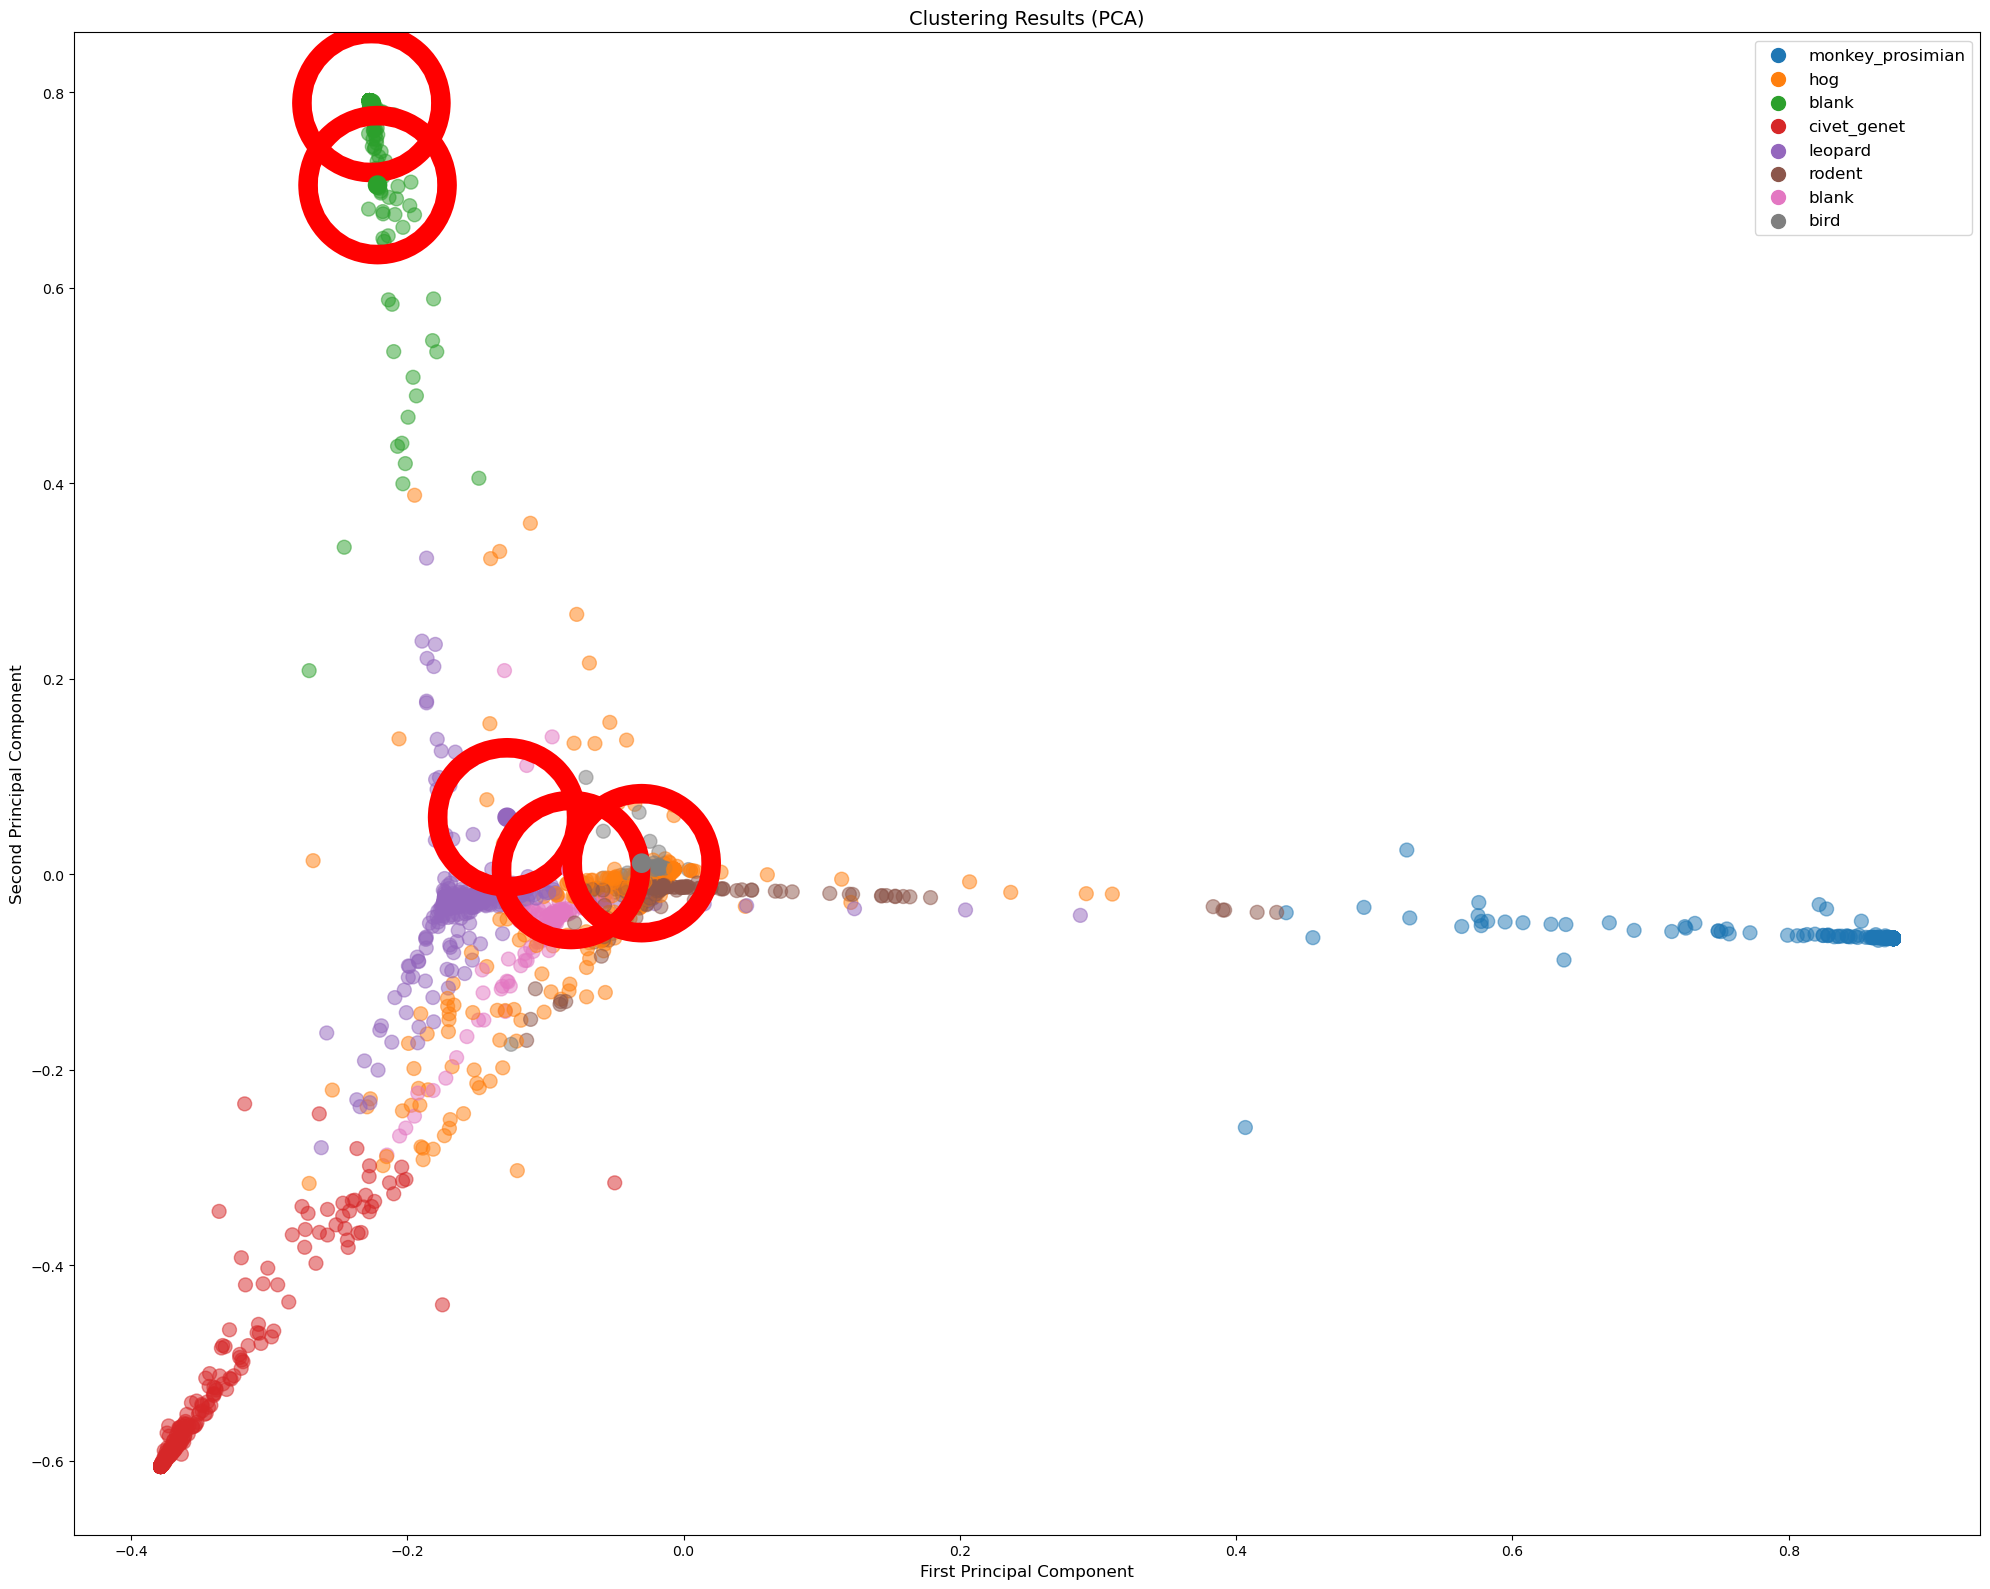

In [12]:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
# PCA for visualization 
pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X) # Map numeric clusters to distinct colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
cluster_colors = {i: color for i, color in enumerate(colors)}

# Choose indices to highlight
highlight_indices = [3298,3299, 3300,3301,3302]  # Replace with  tigers

plt.figure(figsize=(20, 16))

# Plot regular points
mask = ~np.isin(range(len(X_pca)), highlight_indices)
plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
          c=[cluster_colors[i] for i in all_prediction['cluster'][mask]],
          s=100, alpha=0.5)

# Plot highlighted points
plt.scatter(X_pca[highlight_indices, 0], X_pca[highlight_indices, 1],
          c=[cluster_colors[i] for i in all_prediction['cluster'][highlight_indices]],
          s=200, edgecolor='red', linewidth=100)

# Rest of your plotting code remains same
# for i, txt in enumerate(all_prediction.index):
#    plt.annotate(all_prediction['predicted_class'].iloc[i].split('_')[0],
#                (X_pca[i, 0], X_pca[i, 1]),
#                xytext=(5, 5), textcoords='offset points',
#                fontsize=12 if i not in highlight_indices else )

plt.title('Clustering Results (PCA)', fontsize=14)
plt.xlabel('First Principal Component', fontsize=12)
plt.ylabel('Second Principal Component', fontsize=12)
plt.legend(handles=[plt.scatter([], [], c=color, label=class_name, s=100)
                  for class_name, color in zip(class_names.values(), colors)],
         fontsize=12)
plt.tight_layout()
plt.show()